In [1]:
"""
Convolutional Neuroscience
Accademic year 2019-2020
Homework 3

Author: Tommaso Tabarelli
Period: december 2019
"""

# Importing libraries

import argparse
import torch
import json
import re
import numpy as np
from torch.utils.data import Dataset, DataLoader
from functools import reduce
from torch import optim, nn
from network import Network, train_batch
from torch.utils.data import DataLoader
from torchvision import transforms
from pathlib import Path

In [2]:
# Defining network class

class Network(nn.Module):
    
	def __init__(self, input_size, hidden_units, layers_num, dropout_prob=0):
		# Call the parent init function (required!)
		super().__init__()
		# Define recurrent layer
		self.rnn = nn.LSTM(input_size=input_size, 
						hidden_size=hidden_units,
						num_layers=layers_num,
						dropout=dropout_prob,
						batch_first=True)
		# Define output layer
		self.out = nn.Linear(hidden_units, input_size)

	def forward(self, x, state=None):
		# LSTM
		x, rnn_state = self.rnn(x, state)
		# Linear layer
		x = self.out(x)
		return x, rnn_state
    



def train_batch(net, batch_onehot, loss_fn, optimizer):

	### Prepare network input and labels
	# Get the labels (the last letter of each sequence)
	labels_onehot = batch_onehot[:, -1, :]
	labels_numbers = labels_onehot.argmax(dim=1)
	# Remove the labels from the input tensor
	net_input = batch_onehot[:, :-1, :]
	# batch_onehot.shape =   [50, 100, 38]
	# labels_onehot.shape =  [50, 38]
	# labels_numbers.shape = [50]
	# net_input.shape =      [50, 99, 38]

	### Forward pass
	# Eventually clear previous recorded gradients
	optimizer.zero_grad()
	# Forward pass
	net_out, _ = net(net_input)

	### Update network
	# Evaluate loss only for last output
	loss = loss_fn(net_out[:, -1, :], labels_numbers)
	# Backward pass
	loss.backward()
	# Update
	optimizer.step()
	# Return average batch loss
	return float(loss.data)

In [3]:
##############################
##############################
## PARAMETERS
##############################
parser = argparse.ArgumentParser(description='Train the Blake sonnet generator network.')

# Dataset
parser.add_argument('--datasetpath', type=str, default='Songs_of_innocence.txt',
                        help='Path of the train txt file')
parser.add_argument('--crop_len',    type=int, default=100,
                        help='Number of input letters')
#parser.add_argument('--alphabet_len',   type=int,   default=,                help='Number of letters in the alphabet')

# Network
parser.add_argument('--hidden_units',   type=int,   default=128,    help='Number of RNN hidden units')
parser.add_argument('--layers_num',     type=int,   default=2,      help='Number of RNN stacked layers')
parser.add_argument('--dropout_prob',   type=float, default=0.3,    help='Dropout probability')

# Training
parser.add_argument('--batchsize',  type=int, default=154,  help='Training batch size')
parser.add_argument('--num_epochs', type=int, default=1000, help='Number of training epochs')

# Save
parser.add_argument('--out_dir', type=str, default='model', help='Where to save models and params')

_StoreAction(option_strings=['--out_dir'], dest='out_dir', nargs=None, const=None, default='model', type=<class 'str'>, choices=None, help='Where to save models and params', metavar=None)

In [4]:
class WildeDataset(Dataset):
    
    def __init__(self, filepath, crop_len, transform=None):
        
        ### Load data
        text = open(filepath, 'r').read()

        # Removing titles
        text = re.split('\n{7}', text)[1]
        
        # Lowering all text
        text = text.lower()

        # Extract the chapters (divided by '\n{5}')
        chap_list = re.split('\n\n\n\n\n\n', text)
        
        # Remove double new lines
        chap_list = list(map(lambda s: re.sub('\n{2,3}', '\n', s), chap_list))
        # Saving only the chapters which are sufficiently long
        chap_list = [x for x in chap_list if len(x) > crop_len + 100]


        ### Char to number
        alphabet = list(set(text))		# "set" function divides the text in single characters (not ordered)
        alphabet.sort()				# sorting not ordered characters
        print('Found letters:', alphabet)
        # Building dictionaries
        char_to_number = {char: number for number, char in enumerate(alphabet)}
        number_to_char = {number: char for number, char in enumerate(alphabet)}

        ### Store data
        self.chap_list = chap_list
        self.transform = transform
        self.char_to_number = char_to_number
        self.number_to_char = number_to_char
        # In Wilde there are no "stange" chars to encode
        self.alphabet = alphabet
        
    def __len__(self):
        return len(self.chap_list)
        
    def __getitem__(self, idx):
        # Get sonnet text
        text = self.chap_list[idx]
        # Encode with numbers
        encoded = encode_text(self.char_to_number, text)

        # Create sample
        sample = {'text': text, 'encoded': encoded}
        # Transform (if defined)
        if self.transform:
            sample = self.transform(sample)
        return sample


def encode_text(char_to_number, text):
    i = -1
    for c in text:
        i+=1
        try:
            a = char_to_number[c]
        except:	# If the character is not in the char_to_number dictionary, then 
            s = list(text)
            # Encoding the not found characters (if any): "_" is not in the text
            s[i]='_'
            text=''.join(s)
    encoded = [char_to_number[c] for c in text]
    return encoded


def decode_text(number_to_char, encoded):
    text = [number_to_char[c] for c in encoded]
    # Building proper string from a list of strings (concatenating them)
    text = reduce(lambda s1, s2: s1 + s2, text)
    return text


class RandomCrop():
    
    def __init__(self, crop_len):
        self.crop_len = crop_len

    def __call__(self, sample):
        text = sample['text']
        encoded = sample['encoded']
        # Randomly choose an index
        tot_chars = len(text)
        start_idx = np.random.randint(0, tot_chars - self.crop_len)
        end_idx = start_idx + self.crop_len
        return {**sample,
            'text': text[start_idx: end_idx],
            'encoded': encoded[start_idx: end_idx]}
        

def create_one_hot_matrix(encoded, alphabet_len):
    # Create one hot matrix
    encoded_onehot = np.zeros([len(encoded), alphabet_len])
    tot_chars = len(encoded)
    # Placing ONEs at the respective position of the letters: "encoded" indeed have numbers that encode the letters,
    # 	and here it is used as index dimension
    encoded_onehot[np.arange(tot_chars), encoded] = 1
    return encoded_onehot


class OneHotEncoder():
    
    def __init__(self, alphabet_len):
        self.alphabet_len = alphabet_len
        
    def __call__(self, sample):
        # Load encoded text with numbers
        encoded = np.array(sample['encoded'])
        # Create one hot matrix
        encoded_onehot = create_one_hot_matrix(encoded, self.alphabet_len)
        return {**sample,
            'encoded_onehot': encoded_onehot}
        
                
class ToTensor():
    
    def __call__(self, sample):
        # Convert one hot encoded text to pytorch tensor
        encoded_onehot = torch.tensor(sample['encoded_onehot']).float()
        return {'encoded_onehot': encoded_onehot}


## Preparing training the net

In [7]:
# Parse input arguments
training_args = json.load(open('my_training_args_Wilde.json'))

#%% Check device
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print('Selected device:', device)

dataset = WildeDataset(filepath=training_args['datasetpath'], crop_len=training_args['crop_len'],
                    transform=None)

#%% Create dataset
trans = transforms.Compose([RandomCrop(training_args['crop_len']),
                    OneHotEncoder(len(dataset.alphabet)),
                    ToTensor()
                    ])

dataset = WildeDataset(filepath=training_args['datasetpath'], crop_len=training_args['crop_len'],
                    transform=trans)

print("Alphabet length:", len(dataset.alphabet))

#%% Initialize network
net = Network(input_size=len(dataset.alphabet), 
            hidden_units=training_args['hidden_units'], 
            layers_num=training_args['layers_num'], 
            dropout_prob=training_args['dropout_prob'])

net.to(device)

Selected device: cpu
Found letters: ['\n', ' ', '!', '"', "'", ',', '-', '.', '0', '1', '2', '5', '8', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Found letters: ['\n', ' ', '!', '"', "'", ',', '-', '.', '0', '1', '2', '5', '8', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
Alphabet length: 42


Network(
  (rnn): LSTM(42, 1024, num_layers=2, batch_first=True, dropout=0.2)
  (out): Linear(in_features=1024, out_features=42, bias=True)
)

In [8]:
print(training_args)

{'datasetpath': 'Picture_of_Dorian_Gray.txt', 'crop_len': 100, 'hidden_units': 1024, 'layers_num': 2, 'dropout_prob': 0.2, 'batchsize': 200, 'num_epochs': 2000, 'out_dir': 'model_Wilde'}


## Training the net

In [9]:
#%% Train network

# Define Dataloader
dataloader = DataLoader(dataset, batch_size=training_args['batchsize'], shuffle=True, num_workers=1)
# Define optimizer
optimizer = optim.Adam(net.parameters(), weight_decay=5e-4)
# Define loss function
loss_fn = nn.CrossEntropyLoss()

# Defining loss list to plot the losses
loss_list = []

# Start training
for epoch in range(int(training_args['num_epochs'])):
    print('##################################')
    print('## EPOCH '+str(epoch + 1)+"/"+str(int(training_args['num_epochs'])))
    print('##################################')
    # Iterate batches
    for batch_sample in dataloader:
        # Extract batch
        batch_onehot = batch_sample['encoded_onehot'].to(device)
        # Update network
        batch_loss = train_batch(net, batch_onehot, loss_fn, optimizer)
        print('\t Training loss (single batch):', batch_loss)
        loss_list.append(batch_loss)

### Save all needed parameters
# Create output dir
out_dir = Path(training_args['out_dir'])
out_dir.mkdir(parents=True, exist_ok=True)
# Save network parameters
torch.save(net.state_dict(), out_dir / 'net_params.pth')

# Adding alphabet length
training_args["alphabet_len"] = len(dataset.alphabet)
# Save training parameters
with open(out_dir / 'training_args.json', 'w') as f:
    json.dump(training_args, f, indent=4)
# Save encoder dictionary
with open(out_dir / 'char_to_number.json', 'w') as f:
    json.dump(dataset.char_to_number, f, indent=4)
# Save decoder dictionary
with open(out_dir / 'number_to_char.json', 'w') as f:
    json.dump(dataset.number_to_char, f, indent=4)

##################################
## EPOCH 1/2000
##################################
	 Training loss (single batch): 3.7330234050750732
##################################
## EPOCH 2/2000
##################################
	 Training loss (single batch): 3.714447021484375
##################################
## EPOCH 3/2000
##################################
	 Training loss (single batch): 3.6005587577819824
##################################
## EPOCH 4/2000
##################################
	 Training loss (single batch): 3.3599789142608643
##################################
## EPOCH 5/2000
##################################
	 Training loss (single batch): 3.8694164752960205
##################################
## EPOCH 6/2000
##################################
	 Training loss (single batch): 3.9493720531463623
##################################
## EPOCH 7/2000
##################################
	 Training loss (single batch): 3.0818030834198
##################################
## EPOCH 8

	 Training loss (single batch): 3.1339457035064697
##################################
## EPOCH 62/2000
##################################
	 Training loss (single batch): 3.195836305618286
##################################
## EPOCH 63/2000
##################################
	 Training loss (single batch): 3.2510108947753906
##################################
## EPOCH 64/2000
##################################
	 Training loss (single batch): 3.2353644371032715
##################################
## EPOCH 65/2000
##################################
	 Training loss (single batch): 2.858429431915283
##################################
## EPOCH 66/2000
##################################
	 Training loss (single batch): 2.897334337234497
##################################
## EPOCH 67/2000
##################################
	 Training loss (single batch): 3.1212007999420166
##################################
## EPOCH 68/2000
##################################
	 Training loss (single batch): 2.671

	 Training loss (single batch): 2.613550901412964
##################################
## EPOCH 122/2000
##################################
	 Training loss (single batch): 2.916918992996216
##################################
## EPOCH 123/2000
##################################
	 Training loss (single batch): 3.1216204166412354
##################################
## EPOCH 124/2000
##################################
	 Training loss (single batch): 2.5934884548187256
##################################
## EPOCH 125/2000
##################################
	 Training loss (single batch): 2.952993392944336
##################################
## EPOCH 126/2000
##################################
	 Training loss (single batch): 3.3200812339782715
##################################
## EPOCH 127/2000
##################################
	 Training loss (single batch): 2.930323839187622
##################################
## EPOCH 128/2000
##################################
	 Training loss (single batch):

	 Training loss (single batch): 2.5600879192352295
##################################
## EPOCH 182/2000
##################################
	 Training loss (single batch): 2.6846461296081543
##################################
## EPOCH 183/2000
##################################
	 Training loss (single batch): 2.8206372261047363
##################################
## EPOCH 184/2000
##################################
	 Training loss (single batch): 3.0633182525634766
##################################
## EPOCH 185/2000
##################################
	 Training loss (single batch): 2.951064109802246
##################################
## EPOCH 186/2000
##################################
	 Training loss (single batch): 2.7775089740753174
##################################
## EPOCH 187/2000
##################################
	 Training loss (single batch): 2.6475424766540527
##################################
## EPOCH 188/2000
##################################
	 Training loss (single batc

	 Training loss (single batch): 2.6558778285980225
##################################
## EPOCH 242/2000
##################################
	 Training loss (single batch): 2.612200975418091
##################################
## EPOCH 243/2000
##################################
	 Training loss (single batch): 2.4139552116394043
##################################
## EPOCH 244/2000
##################################
	 Training loss (single batch): 2.7638700008392334
##################################
## EPOCH 245/2000
##################################
	 Training loss (single batch): 2.4769110679626465
##################################
## EPOCH 246/2000
##################################
	 Training loss (single batch): 2.493340253829956
##################################
## EPOCH 247/2000
##################################
	 Training loss (single batch): 2.5659708976745605
##################################
## EPOCH 248/2000
##################################
	 Training loss (single batch

	 Training loss (single batch): 2.3321356773376465
##################################
## EPOCH 302/2000
##################################
	 Training loss (single batch): 2.3442158699035645
##################################
## EPOCH 303/2000
##################################
	 Training loss (single batch): 1.9688352346420288
##################################
## EPOCH 304/2000
##################################
	 Training loss (single batch): 2.1412291526794434
##################################
## EPOCH 305/2000
##################################
	 Training loss (single batch): 2.161067247390747
##################################
## EPOCH 306/2000
##################################
	 Training loss (single batch): 2.6531643867492676
##################################
## EPOCH 307/2000
##################################
	 Training loss (single batch): 2.351013660430908
##################################
## EPOCH 308/2000
##################################
	 Training loss (single batch

	 Training loss (single batch): 2.393991470336914
##################################
## EPOCH 362/2000
##################################
	 Training loss (single batch): 2.2185778617858887
##################################
## EPOCH 363/2000
##################################
	 Training loss (single batch): 2.2773048877716064
##################################
## EPOCH 364/2000
##################################
	 Training loss (single batch): 2.4335227012634277
##################################
## EPOCH 365/2000
##################################
	 Training loss (single batch): 2.9041666984558105
##################################
## EPOCH 366/2000
##################################
	 Training loss (single batch): 2.3319530487060547
##################################
## EPOCH 367/2000
##################################
	 Training loss (single batch): 2.4607362747192383
##################################
## EPOCH 368/2000
##################################
	 Training loss (single batc

	 Training loss (single batch): 1.7703453302383423
##################################
## EPOCH 422/2000
##################################
	 Training loss (single batch): 2.4509947299957275
##################################
## EPOCH 423/2000
##################################
	 Training loss (single batch): 1.969513177871704
##################################
## EPOCH 424/2000
##################################
	 Training loss (single batch): 2.1670868396759033
##################################
## EPOCH 425/2000
##################################
	 Training loss (single batch): 2.1948354244232178
##################################
## EPOCH 426/2000
##################################
	 Training loss (single batch): 1.8852462768554688
##################################
## EPOCH 427/2000
##################################
	 Training loss (single batch): 1.7720019817352295
##################################
## EPOCH 428/2000
##################################
	 Training loss (single batc

	 Training loss (single batch): 1.5388085842132568
##################################
## EPOCH 482/2000
##################################
	 Training loss (single batch): 1.590653657913208
##################################
## EPOCH 483/2000
##################################
	 Training loss (single batch): 1.6606075763702393
##################################
## EPOCH 484/2000
##################################
	 Training loss (single batch): 1.8154255151748657
##################################
## EPOCH 485/2000
##################################
	 Training loss (single batch): 1.734630823135376
##################################
## EPOCH 486/2000
##################################
	 Training loss (single batch): 1.7688030004501343
##################################
## EPOCH 487/2000
##################################
	 Training loss (single batch): 1.6055490970611572
##################################
## EPOCH 488/2000
##################################
	 Training loss (single batch

	 Training loss (single batch): 1.8247371912002563
##################################
## EPOCH 542/2000
##################################
	 Training loss (single batch): 1.892677664756775
##################################
## EPOCH 543/2000
##################################
	 Training loss (single batch): 1.3733460903167725
##################################
## EPOCH 544/2000
##################################
	 Training loss (single batch): 1.3112621307373047
##################################
## EPOCH 545/2000
##################################
	 Training loss (single batch): 1.0042405128479004
##################################
## EPOCH 546/2000
##################################
	 Training loss (single batch): 1.3696215152740479
##################################
## EPOCH 547/2000
##################################
	 Training loss (single batch): 1.2740421295166016
##################################
## EPOCH 548/2000
##################################
	 Training loss (single batc

	 Training loss (single batch): 1.6149202585220337
##################################
## EPOCH 602/2000
##################################
	 Training loss (single batch): 1.0333173274993896
##################################
## EPOCH 603/2000
##################################
	 Training loss (single batch): 1.1591180562973022
##################################
## EPOCH 604/2000
##################################
	 Training loss (single batch): 1.5602004528045654
##################################
## EPOCH 605/2000
##################################
	 Training loss (single batch): 0.7041146755218506
##################################
## EPOCH 606/2000
##################################
	 Training loss (single batch): 0.8895577192306519
##################################
## EPOCH 607/2000
##################################
	 Training loss (single batch): 0.8395625352859497
##################################
## EPOCH 608/2000
##################################
	 Training loss (single bat

	 Training loss (single batch): 0.4192579388618469
##################################
## EPOCH 661/2000
##################################
	 Training loss (single batch): 0.5959655046463013
##################################
## EPOCH 662/2000
##################################
	 Training loss (single batch): 0.4988740086555481
##################################
## EPOCH 663/2000
##################################
	 Training loss (single batch): 0.6311009526252747
##################################
## EPOCH 664/2000
##################################
	 Training loss (single batch): 0.48495665192604065
##################################
## EPOCH 665/2000
##################################
	 Training loss (single batch): 0.5438826084136963
##################################
## EPOCH 666/2000
##################################
	 Training loss (single batch): 0.4076942503452301
##################################
## EPOCH 667/2000
##################################
	 Training loss (single ba

	 Training loss (single batch): 0.9178274869918823
##################################
## EPOCH 720/2000
##################################
	 Training loss (single batch): 0.8337922096252441
##################################
## EPOCH 721/2000
##################################
	 Training loss (single batch): 0.2601228356361389
##################################
## EPOCH 722/2000
##################################
	 Training loss (single batch): 0.39925819635391235
##################################
## EPOCH 723/2000
##################################
	 Training loss (single batch): 0.3194713294506073
##################################
## EPOCH 724/2000
##################################
	 Training loss (single batch): 0.43075627088546753
##################################
## EPOCH 725/2000
##################################
	 Training loss (single batch): 0.40721410512924194
##################################
## EPOCH 726/2000
##################################
	 Training loss (single 

	 Training loss (single batch): 0.29336968064308167
##################################
## EPOCH 779/2000
##################################
	 Training loss (single batch): 0.6845381855964661
##################################
## EPOCH 780/2000
##################################
	 Training loss (single batch): 0.34460577368736267
##################################
## EPOCH 781/2000
##################################
	 Training loss (single batch): 0.2725420296192169
##################################
## EPOCH 782/2000
##################################
	 Training loss (single batch): 0.2756248414516449
##################################
## EPOCH 783/2000
##################################
	 Training loss (single batch): 0.386929452419281
##################################
## EPOCH 784/2000
##################################
	 Training loss (single batch): 0.259137362241745
##################################
## EPOCH 785/2000
##################################
	 Training loss (single bat

	 Training loss (single batch): 0.0817193016409874
##################################
## EPOCH 838/2000
##################################
	 Training loss (single batch): 0.36309072375297546
##################################
## EPOCH 839/2000
##################################
	 Training loss (single batch): 0.2744331359863281
##################################
## EPOCH 840/2000
##################################
	 Training loss (single batch): 0.06898389756679535
##################################
## EPOCH 841/2000
##################################
	 Training loss (single batch): 0.18534395098686218
##################################
## EPOCH 842/2000
##################################
	 Training loss (single batch): 0.3285239338874817
##################################
## EPOCH 843/2000
##################################
	 Training loss (single batch): 0.05330870673060417
##################################
## EPOCH 844/2000
##################################
	 Training loss (single

	 Training loss (single batch): 0.13128350675106049
##################################
## EPOCH 897/2000
##################################
	 Training loss (single batch): 0.11393831670284271
##################################
## EPOCH 898/2000
##################################
	 Training loss (single batch): 0.2619298994541168
##################################
## EPOCH 899/2000
##################################
	 Training loss (single batch): 0.19198258221149445
##################################
## EPOCH 900/2000
##################################
	 Training loss (single batch): 0.12053124606609344
##################################
## EPOCH 901/2000
##################################
	 Training loss (single batch): 0.1643684208393097
##################################
## EPOCH 902/2000
##################################
	 Training loss (single batch): 0.09937892854213715
##################################
## EPOCH 903/2000
##################################
	 Training loss (singl

	 Training loss (single batch): 0.0243825800716877
##################################
## EPOCH 956/2000
##################################
	 Training loss (single batch): 0.029271453619003296
##################################
## EPOCH 957/2000
##################################
	 Training loss (single batch): 0.03289567306637764
##################################
## EPOCH 958/2000
##################################
	 Training loss (single batch): 0.35994797945022583
##################################
## EPOCH 959/2000
##################################
	 Training loss (single batch): 0.06422159820795059
##################################
## EPOCH 960/2000
##################################
	 Training loss (single batch): 0.3604097068309784
##################################
## EPOCH 961/2000
##################################
	 Training loss (single batch): 0.07850762456655502
##################################
## EPOCH 962/2000
##################################
	 Training loss (sing

	 Training loss (single batch): 0.08340305835008621
##################################
## EPOCH 1015/2000
##################################
	 Training loss (single batch): 0.09831524640321732
##################################
## EPOCH 1016/2000
##################################
	 Training loss (single batch): 0.09641969203948975
##################################
## EPOCH 1017/2000
##################################
	 Training loss (single batch): 0.051516342908144
##################################
## EPOCH 1018/2000
##################################
	 Training loss (single batch): 0.03722304850816727
##################################
## EPOCH 1019/2000
##################################
	 Training loss (single batch): 0.05077679082751274
##################################
## EPOCH 1020/2000
##################################
	 Training loss (single batch): 0.15680964291095734
##################################
## EPOCH 1021/2000
##################################
	 Training loss

	 Training loss (single batch): 0.03108702227473259
##################################
## EPOCH 1074/2000
##################################
	 Training loss (single batch): 0.04296967759728432
##################################
## EPOCH 1075/2000
##################################
	 Training loss (single batch): 0.11291539669036865
##################################
## EPOCH 1076/2000
##################################
	 Training loss (single batch): 0.023578858003020287
##################################
## EPOCH 1077/2000
##################################
	 Training loss (single batch): 0.6028234362602234
##################################
## EPOCH 1078/2000
##################################
	 Training loss (single batch): 0.06698460876941681
##################################
## EPOCH 1079/2000
##################################
	 Training loss (single batch): 0.04955080896615982
##################################
## EPOCH 1080/2000
##################################
	 Training lo

	 Training loss (single batch): 0.13616423308849335
##################################
## EPOCH 1133/2000
##################################
	 Training loss (single batch): 0.5981224775314331
##################################
## EPOCH 1134/2000
##################################
	 Training loss (single batch): 0.4068250060081482
##################################
## EPOCH 1135/2000
##################################
	 Training loss (single batch): 0.2482515573501587
##################################
## EPOCH 1136/2000
##################################
	 Training loss (single batch): 0.29412898421287537
##################################
## EPOCH 1137/2000
##################################
	 Training loss (single batch): 0.2426864206790924
##################################
## EPOCH 1138/2000
##################################
	 Training loss (single batch): 0.40270060300827026
##################################
## EPOCH 1139/2000
##################################
	 Training loss (

	 Training loss (single batch): 0.06208556145429611
##################################
## EPOCH 1192/2000
##################################
	 Training loss (single batch): 0.07802566885948181
##################################
## EPOCH 1193/2000
##################################
	 Training loss (single batch): 0.05546460673213005
##################################
## EPOCH 1194/2000
##################################
	 Training loss (single batch): 0.37142127752304077
##################################
## EPOCH 1195/2000
##################################
	 Training loss (single batch): 0.5766283273696899
##################################
## EPOCH 1196/2000
##################################
	 Training loss (single batch): 0.17269445955753326
##################################
## EPOCH 1197/2000
##################################
	 Training loss (single batch): 0.032972302287817
##################################
## EPOCH 1198/2000
##################################
	 Training loss 

	 Training loss (single batch): 0.03972078114748001
##################################
## EPOCH 1251/2000
##################################
	 Training loss (single batch): 0.2117583304643631
##################################
## EPOCH 1252/2000
##################################
	 Training loss (single batch): 0.022031938657164574
##################################
## EPOCH 1253/2000
##################################
	 Training loss (single batch): 0.046680234372615814
##################################
## EPOCH 1254/2000
##################################
	 Training loss (single batch): 0.08316444605588913
##################################
## EPOCH 1255/2000
##################################
	 Training loss (single batch): 0.03939235210418701
##################################
## EPOCH 1256/2000
##################################
	 Training loss (single batch): 0.028411924839019775
##################################
## EPOCH 1257/2000
##################################
	 Training 

	 Training loss (single batch): 0.03785286098718643
##################################
## EPOCH 1309/2000
##################################
	 Training loss (single batch): 0.04530138522386551
##################################
## EPOCH 1310/2000
##################################
	 Training loss (single batch): 0.03587905690073967
##################################
## EPOCH 1311/2000
##################################
	 Training loss (single batch): 0.019820336252450943
##################################
## EPOCH 1312/2000
##################################
	 Training loss (single batch): 0.024200668558478355
##################################
## EPOCH 1313/2000
##################################
	 Training loss (single batch): 0.03707712143659592
##################################
## EPOCH 1314/2000
##################################
	 Training loss (single batch): 0.028740322217345238
##################################
## EPOCH 1315/2000
##################################
	 Training

	 Training loss (single batch): 0.02042810060083866
##################################
## EPOCH 1367/2000
##################################
	 Training loss (single batch): 0.014335652813315392
##################################
## EPOCH 1368/2000
##################################
	 Training loss (single batch): 0.010662222281098366
##################################
## EPOCH 1369/2000
##################################
	 Training loss (single batch): 0.021285252645611763
##################################
## EPOCH 1370/2000
##################################
	 Training loss (single batch): 0.01726742647588253
##################################
## EPOCH 1371/2000
##################################
	 Training loss (single batch): 0.024659017100930214
##################################
## EPOCH 1372/2000
##################################
	 Training loss (single batch): 0.029298510402441025
##################################
## EPOCH 1373/2000
##################################
	 Traini

	 Training loss (single batch): 0.048238955438137054
##################################
## EPOCH 1425/2000
##################################
	 Training loss (single batch): 0.020484521985054016
##################################
## EPOCH 1426/2000
##################################
	 Training loss (single batch): 0.025828948244452477
##################################
## EPOCH 1427/2000
##################################
	 Training loss (single batch): 0.1143639087677002
##################################
## EPOCH 1428/2000
##################################
	 Training loss (single batch): 0.06301866471767426
##################################
## EPOCH 1429/2000
##################################
	 Training loss (single batch): 0.01252411026507616
##################################
## EPOCH 1430/2000
##################################
	 Training loss (single batch): 0.13167747855186462
##################################
## EPOCH 1431/2000
##################################
	 Training 

	 Training loss (single batch): 0.030591245740652084
##################################
## EPOCH 1484/2000
##################################
	 Training loss (single batch): 0.06324408203363419
##################################
## EPOCH 1485/2000
##################################
	 Training loss (single batch): 0.4523347318172455
##################################
## EPOCH 1486/2000
##################################
	 Training loss (single batch): 0.036155253648757935
##################################
## EPOCH 1487/2000
##################################
	 Training loss (single batch): 0.030083278194069862
##################################
## EPOCH 1488/2000
##################################
	 Training loss (single batch): 0.19848047196865082
##################################
## EPOCH 1489/2000
##################################
	 Training loss (single batch): 0.07117731869220734
##################################
## EPOCH 1490/2000
##################################
	 Training 

	 Training loss (single batch): 0.03808301314711571
##################################
## EPOCH 1543/2000
##################################
	 Training loss (single batch): 0.10636729001998901
##################################
## EPOCH 1544/2000
##################################
	 Training loss (single batch): 0.17459706962108612
##################################
## EPOCH 1545/2000
##################################
	 Training loss (single batch): 0.11275158822536469
##################################
## EPOCH 1546/2000
##################################
	 Training loss (single batch): 0.07289476692676544
##################################
## EPOCH 1547/2000
##################################
	 Training loss (single batch): 0.017433706670999527
##################################
## EPOCH 1548/2000
##################################
	 Training loss (single batch): 0.23954994976520538
##################################
## EPOCH 1549/2000
##################################
	 Training l

	 Training loss (single batch): 0.05553331971168518
##################################
## EPOCH 1602/2000
##################################
	 Training loss (single batch): 0.05422665923833847
##################################
## EPOCH 1603/2000
##################################
	 Training loss (single batch): 0.0660957545042038
##################################
## EPOCH 1604/2000
##################################
	 Training loss (single batch): 0.03021577000617981
##################################
## EPOCH 1605/2000
##################################
	 Training loss (single batch): 0.04222216457128525
##################################
## EPOCH 1606/2000
##################################
	 Training loss (single batch): 0.2528015077114105
##################################
## EPOCH 1607/2000
##################################
	 Training loss (single batch): 0.09776289761066437
##################################
## EPOCH 1608/2000
##################################
	 Training loss

	 Training loss (single batch): 0.03558903560042381
##################################
## EPOCH 1661/2000
##################################
	 Training loss (single batch): 0.1466304212808609
##################################
## EPOCH 1662/2000
##################################
	 Training loss (single batch): 0.0685172751545906
##################################
## EPOCH 1663/2000
##################################
	 Training loss (single batch): 0.1952449083328247
##################################
## EPOCH 1664/2000
##################################
	 Training loss (single batch): 0.17337295413017273
##################################
## EPOCH 1665/2000
##################################
	 Training loss (single batch): 0.04357288405299187
##################################
## EPOCH 1666/2000
##################################
	 Training loss (single batch): 0.22528593242168427
##################################
## EPOCH 1667/2000
##################################
	 Training loss 

	 Training loss (single batch): 0.10774751007556915
##################################
## EPOCH 1720/2000
##################################
	 Training loss (single batch): 0.025344859808683395
##################################
## EPOCH 1721/2000
##################################
	 Training loss (single batch): 0.021513577550649643
##################################
## EPOCH 1722/2000
##################################
	 Training loss (single batch): 0.025665462017059326
##################################
## EPOCH 1723/2000
##################################
	 Training loss (single batch): 0.017899777740240097
##################################
## EPOCH 1724/2000
##################################
	 Training loss (single batch): 0.05997225642204285
##################################
## EPOCH 1725/2000
##################################
	 Training loss (single batch): 0.02912328764796257
##################################
## EPOCH 1726/2000
##################################
	 Trainin

	 Training loss (single batch): 0.05209122225642204
##################################
## EPOCH 1778/2000
##################################
	 Training loss (single batch): 0.01740211248397827
##################################
## EPOCH 1779/2000
##################################
	 Training loss (single batch): 0.039551589637994766
##################################
## EPOCH 1780/2000
##################################
	 Training loss (single batch): 0.02310037612915039
##################################
## EPOCH 1781/2000
##################################
	 Training loss (single batch): 0.012193648144602776
##################################
## EPOCH 1782/2000
##################################
	 Training loss (single batch): 0.1280525028705597
##################################
## EPOCH 1783/2000
##################################
	 Training loss (single batch): 0.024208854883909225
##################################
## EPOCH 1784/2000
##################################
	 Training 

	 Training loss (single batch): 0.016587939113378525
##################################
## EPOCH 1836/2000
##################################
	 Training loss (single batch): 0.016009708866477013
##################################
## EPOCH 1837/2000
##################################
	 Training loss (single batch): 0.024898206815123558
##################################
## EPOCH 1838/2000
##################################
	 Training loss (single batch): 0.00827783439308405
##################################
## EPOCH 1839/2000
##################################
	 Training loss (single batch): 0.020440038293600082
##################################
## EPOCH 1840/2000
##################################
	 Training loss (single batch): 0.024291953071951866
##################################
## EPOCH 1841/2000
##################################
	 Training loss (single batch): 0.012643826194107533
##################################
## EPOCH 1842/2000
##################################
	 Train

	 Training loss (single batch): 0.025544684380292892
##################################
## EPOCH 1894/2000
##################################
	 Training loss (single batch): 0.04274987429380417
##################################
## EPOCH 1895/2000
##################################
	 Training loss (single batch): 0.025964077562093735
##################################
## EPOCH 1896/2000
##################################
	 Training loss (single batch): 0.02027789130806923
##################################
## EPOCH 1897/2000
##################################
	 Training loss (single batch): 0.02180483750998974
##################################
## EPOCH 1898/2000
##################################
	 Training loss (single batch): 0.023926418274641037
##################################
## EPOCH 1899/2000
##################################
	 Training loss (single batch): 0.023855384439229965
##################################
## EPOCH 1900/2000
##################################
	 Trainin

	 Training loss (single batch): 0.009715486317873001
##################################
## EPOCH 1952/2000
##################################
	 Training loss (single batch): 0.005977065768092871
##################################
## EPOCH 1953/2000
##################################
	 Training loss (single batch): 0.010756591334939003
##################################
## EPOCH 1954/2000
##################################
	 Training loss (single batch): 0.004972910974174738
##################################
## EPOCH 1955/2000
##################################
	 Training loss (single batch): 0.0052115218713879585
##################################
## EPOCH 1956/2000
##################################
	 Training loss (single batch): 0.007398795336484909
##################################
## EPOCH 1957/2000
##################################
	 Training loss (single batch): 0.01231884304434061
##################################
## EPOCH 1958/2000
##################################
	 Trai

### Plotting losses

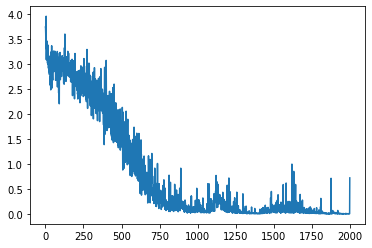

In [12]:
import matplotlib.pyplot as plt

loss_list = np.array(loss_list)

plt.plot(loss_list)
plt.show()

In [15]:
##############################
##############################
## PARAMETERS
##############################
#parser = argparse.ArgumentParser(description='Generate sonnet starting from a given text')

#parser.add_argument('--sonnet_seed', type=str, default='the', help='Initial text of the sonnet')
#parser.add_argument('--model_dir',   type=str, default='pretrained_models/model_3', help='Network model directory')

##############################
##############################
##############################

### Parse input arguments
#args = parser.parse_args()

model_dir = Path("model_Wilde/")
sonnet_seed = "dorian was staring at his portrait"

#%% Load training parameters
#model_dir = Path("model_Wilde_2019-12-05_17:38/")
print ('Loading model from: %s' % model_dir)
training_args = json.load(open(model_dir / 'training_args.json'))

#%% Load encoder and decoder dictionaries
number_to_char = json.load(open(model_dir / 'number_to_char.json'))
char_to_number = json.load(open(model_dir / 'char_to_number.json'))

#%% Initialize network
net = Network(input_size=training_args['alphabet_len'], 
            hidden_units=training_args['hidden_units'], 
            layers_num=training_args['layers_num'])

#%% Load network trained parameters
net.load_state_dict(torch.load(model_dir / 'net_params.pth', map_location='cpu'))
net.eval() # Evaluation mode (e.g. disable dropout)

#%% Find initial state of the RNN
with torch.no_grad():
    # Encode seed
    seed_encoded = encode_text(char_to_number, sonnet_seed)
    # One hot matrix
    seed_onehot = create_one_hot_matrix(seed_encoded, training_args['alphabet_len'])
    # To tensor
    seed_onehot = torch.tensor(seed_onehot).float()
    # Add batch axis
    seed_onehot = seed_onehot.unsqueeze(0)
    # Forward pass
    net_out, net_state = net(seed_onehot)
    # Get the most probable last output index
    # ---------- sampling using softmax ----------
    next_char_encoded = net_out[:, -1, :].argmax().item()
    # Print the seed letters
    print(sonnet_seed, end='', flush=True)
    print(number_to_char[str(next_char_encoded)])

#%% Generate sonnet
new_line_count = 0
tot_char_count = 0
while True:
    with torch.no_grad(): # No need to track the gradients
        # The new network input is the one hot encoding of the last chosen letter
        net_input = create_one_hot_matrix([next_char_encoded], len(dataset.alphabet))
        net_input = torch.tensor(net_input).float()
        net_input = net_input.unsqueeze(0)
        # Forward pass
        net_out, net_state = net(net_input, net_state)
        # Get the most probable letter index
        
        # Using softmax instead of argmax
        distrib = np.array(nn.functional.softmax(net_out, dim=-1))
        next_char_encoded = np.random.choice(len(distrib.ravel()), size=1, p=distrib.ravel())[0]
        
        # Get the most probable letter index
        #next_char_encoded = net_out.argmax().item()
        # Decode the letter
        next_char = number_to_char[str(next_char_encoded)]
        #next_char_encoded = net_out.argmax().item()
        
        # Decode the letter
        #next_char = number_to_char[str(next_char_encoded)]
        
        print(next_char, end='', flush=True)
        # Count total letters
        tot_char_count += 1
        # Count new lines
        if next_char == '\n':
            new_line_count += 1
        # Break if 14 lines or 2000 letters
        if new_line_count == 14 or tot_char_count > 2000:
            break

Loading model from: model_Wilde
dorian was staring at his portraitm
m.

 phitrsssuussenn  uu waeee oop!yemen ouaceed and oo itagtigtssyrinn oh h s u whi.. mopen phe toarvyctn p uewe he hsyyin i ahrthe  oarwhes oummeed me coarwade  uaft.ed bide
  u 1rg..  oroseem mhem
 ued boueed  hectover th t lede oo.yp?ttttetl uuusaee  oarddppude
 aude seti th llis uh ysal; h uen wou poied ouyymeve ciuedy th i seiri hed wouetd tof t thill miued pun peee ar in bnese hel b uetthe  oarthhe  omedeppuue
ettuntee siureee uureee  ha tovcra pouyw.hd  uaccaae  oarwhhd mude
 pe cseee lid a tofesedd oupedes ned i hetncded au tourwaae  hay porowhpe ao"rwhem aud a uetthe  uaetaad  ta taee litos seuriled aude agtto tale oouesedd
 mumett f . :he lles yhim youen ofp tomgwhes ohyy miurwofed  h pgled huu 0fyrin bi oi wilee oi yeyvris uncctlrrgci . wher liu a uhalhd pimee hed i tetlen hiue
 au peeeryitsds uuned fg oa wtuet oh m l uses hedm otcy hhd wissssit led b toseee oueye serrtoar lh t uew.hem pemctee  oarwhctgvisv